In [86]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [105]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [106]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [89]:
def view_random_image(data):
    rand_cat = random.sample(list(train_data['category'].unique()),1)
    rand_img = random.sample(list(data[data['category']==rand_cat[0]]['image_path']),1)

    img = mpimg.imread(rand_img[0])
    plt.imshow(img)
    plt.title(rand_cat[0])
    plt.axis('off')

    print(f'Image shape: {img.shape}')

    return img

def loss_curves(cnn):
    loss = cnn.history['loss']
    val_loss = cnn.history['val_loss']

    accuracy = cnn.history['accuracy']
    val_accuracy = cnn.history['val_accuracy']

    epochs = range(len(cnn.history['loss']))

    plt.plot(epochs, loss, label= "training_loss")
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('loss')
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label= "training_accuracy")
    plt.plot(epochs, val_accuracy, label='validation_accuracy')
    plt.title('accuracy')
    plt.xlabel("epochs")
    plt.legend()


## Load Train/Test Set

In [90]:
dir = '../data/food-101'
# Load the category labels
labels_file = dir+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

# Load the training dataset
train_file = dir+'/train.txt'
train_data = pd.read_csv(train_file, header=None, names=['category_filename'], dtype=str)
train_data['category'] = train_data['category_filename'].apply(lambda x: x.split('/')[0])
train_data['filename'] = train_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
train_data['filename'] = train_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
train_data['image_path'] = train_data.apply(lambda row: os.path.join(dir, 'images', row['category'], row['filename']), axis=1)

print (train_data.shape)

# Load the testing dataset
test_file = dir+'/test.txt'
test_data = pd.read_csv(test_file, header=None, names=['category_filename'], dtype=str)
test_data['category'] = test_data['category_filename'].apply(lambda x: x.split('/')[0])
test_data['filename'] = test_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
test_data['filename'] = test_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
test_data['image_path'] = test_data.apply(lambda row: os.path.join(dir, 'images', row['category'], row['filename']), axis=1)

print (test_data.shape)

(75750, 4)
(25250, 4)


Image shape: (512, 512, 3)


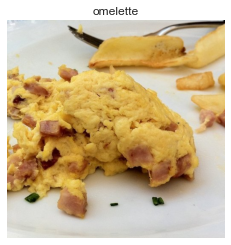

In [91]:
x = view_random_image(train_data)

## Preprocess Data

In [107]:
# Rescale/normalize images

train_gen = ImageDataGenerator(rescale=1/255.)

train_gen_aug = ImageDataGenerator(rescale=1/255.,
                               rotation_range= 0.2,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True)

test_gen = ImageDataGenerator(rescale=1/255.)


In [108]:
# load image categories and filepaths from dataframe
tf_train_data = train_gen.flow_from_dataframe(train_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=32)
tf_train_data_aug = train_gen_aug.flow_from_dataframe(train_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=32)

tf_test_data = test_gen.flow_from_dataframe(test_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=32)


Found 75750 validated image filenames belonging to 101 classes.
Found 75750 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


## Create baseline CNN model

In [112]:
baseline = tf.keras.models.Sequential([
    layers.Conv2D(filters=10,
           kernel_size=3,
           activation='relu',
           input_shape=(224,224,3)),
    layers.Conv2D(10,3,activation="relu"),
    layers.MaxPool2D(pool_size=2,padding='valid'),
    layers.Conv2D(10,3,activation="relu"),
    layers.Conv2D(10,3,activation="relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(101),
    layers.Activation("softmax",dtype=tf.float32)])

baseline.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

In [113]:
base_1 = baseline.fit(tf_train_data,
                        epochs=5,
                        steps_per_epoch=len(tf_train_data),
                        validation_data=tf_test_data,
                        validation_steps=len(tf_test_data))

Epoch 1/5
2368/2368 [==============================] - 162s 68ms/step - loss: 4.3119 - accuracy: 0.0597 - val_loss: 3.9329 - val_accuracy: 0.1179
Epoch 2/5
2368/2368 [==============================] - 174s 73ms/step - loss: 3.4460 - accuracy: 0.2170 - val_loss: 3.9666 - val_accuracy: 0.1195
Epoch 3/5
2368/2368 [==============================] - 179s 76ms/step - loss: 1.6713 - accuracy: 0.5871 - val_loss: 5.4681 - val_accuracy: 0.0878
Epoch 4/5
2368/2368 [==============================] - 175s 74ms/step - loss: 0.3448 - accuracy: 0.9121 - val_loss: 9.5245 - val_accuracy: 0.0727
Epoch 5/5
2368/2368 [==============================] - 166s 70ms/step - loss: 0.0796 - accuracy: 0.9795 - val_loss: 12.9191 - val_accuracy: 0.0676


Loss for validation increasing is an indication of overfitting

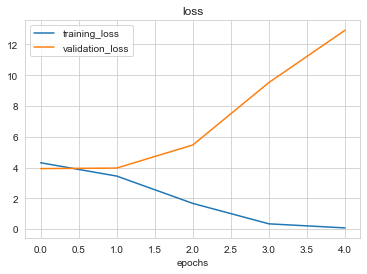

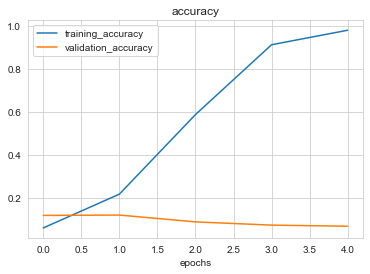

In [114]:
loss_curves(base_1)

In [115]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3), name='input_layer')

x = base_model(inputs, training=False)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(101)(x)
outputs = layers.Activation("softmax",dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [117]:
hist_base = model.fit(tf_train_data,
                      epochs=3,
                      steps_per_epoch=len(tf_train_data),
                      validation_data=tf_test_data,
                      validation_steps=int(0.15 * len(tf_test_data)))

Epoch 1/3
2368/2368 [==============================] - 279s 116ms/step - loss: 4.6453 - accuracy: 0.0105 - val_loss: 4.6515 - val_accuracy: 0.0124
Epoch 2/3
2368/2368 [==============================] - 275s 116ms/step - loss: 4.6420 - accuracy: 0.0105 - val_loss: 4.6396 - val_accuracy: 0.0074
Epoch 3/3
2368/2368 [==============================] - 275s 116ms/step - loss: 4.6392 - accuracy: 0.0109 - val_loss: 4.6315 - val_accuracy: 0.0098
